In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pip install imblearn
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

### import the cleaned dataset

In [4]:
df = pd.read_csv("data/framingham_cleaned.csv", index_col= 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3817 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3817 non-null   int64  
 1   age              3817 non-null   int64  
 2   education        3817 non-null   int64  
 3   currentSmoker    3817 non-null   int64  
 4   cigsPerDay       3817 non-null   int64  
 5   BPMeds           3817 non-null   int64  
 6   prevalentStroke  3817 non-null   int64  
 7   prevalentHyp     3817 non-null   int64  
 8   diabetes         3817 non-null   int64  
 9   totChol          3817 non-null   int64  
 10  sysBP            3817 non-null   float64
 11  diaBP            3817 non-null   float64
 12  BMI              3817 non-null   int64  
 13  heartRate        3817 non-null   float64
 14  glucose          3817 non-null   int64  
 15  TenYearCHD       3817 non-null   int64  
dtypes: float64(3), int64(13)
memory usage: 506.9 KB


In [5]:
df["TenYearCHD"].value_counts()

TenYearCHD
0    3174
1     643
Name: count, dtype: int64

In [24]:
X = df.drop(["TenYearCHD"], axis = 1)
y = df["TenYearCHD"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 11)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(3053, 15)
(3053,)
(764, 15)
(764,)


In [ ]:

pipeline = Pipeline(steps = [
    ('undersample', RandomUnderSampler(sampling_strategy=0.33, random_state=42)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42))
])



param_grid = {
    'model__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'model__class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:5}, 'balanced'],
    'model__solver': ['liblinear', 'lbfgs'],
    'model__max_iter': [100, 1000, 10000]
}


grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1,
   )

grid.fit(X_train, y_train)


print(f"Best recall {grid.best_score_}")
print(f"Best params: {grid.best_params_}")

# best model
best_model = grid.best_estimator_





Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best recall 0.841080586080586
Best params: {'model__C': 0.01, 'model__class_weight': {0: 1, 1: 5}, 'model__max_iter': 100, 'model__solver': 'lbfgs'}


### Evaluation and visualization 

BEST MODEL EVALUATION
Best Parameters: {'model__C': 0.01, 'model__class_weight': {0: 1, 1: 5}, 'model__max_iter': 100, 'model__solver': 'lbfgs'}
Best CV Score: 0.8411

1. TEST ACCURACY: 0.5654 (56.54%)

2. CONFUSION MATRIX:
┌─────────────────────────┐
│   Actual \ Predicted    │
├─────────────┬───────────┤
│             │  0  │  1  │
├─────────────┼─────┼─────┤
│0 (No CHD)   │ 339 │ 304 │
├─────────────┼─────┼─────┤
│1 (CHD)      │ 28  │ 93  │
└─────────────┴─────┴─────┘

Detailed Breakdown:
• True Negatives  (TN):  339 - Correctly predicted no CHD
• False Positives (FP):  304 - No CHD predicted as CHD (Type I)
• False Negatives (FN):   28 - CHD predicted as no CHD (Type II)
• True Positives  (TP):   93 - Correctly predicted CHD

3. KEY METRICS FROM CONFUSION MATRIX:
   Precision (PPV):  0.2343 (23.43%)
   Recall (Sensitivity): 0.7686 (76.86%)
   Specificity:      0.5272 (52.72%)
   F1-Score:         0.3591 (35.91%)

4. CLASSIFICATION REPORT:
              precision    recall  f1-score

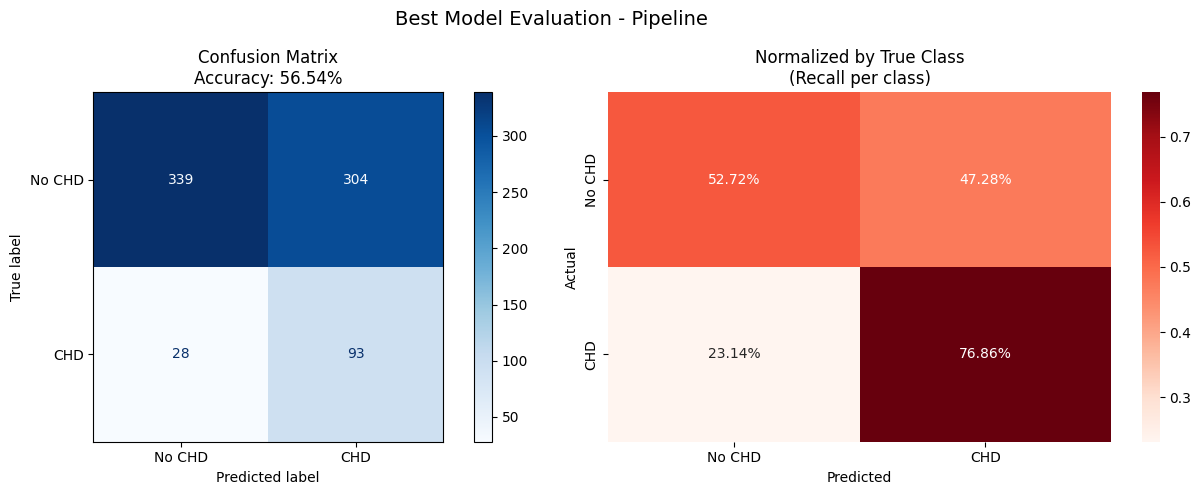


5. MEDICAL CONTEXT METRICS (for Framingham CHD):
• Negative Predictive Value (NPV): 92.37%
• False Positive Rate (FPR): 47.28%
• False Negative Rate (FNR): 23.14%
• Prevalence in test set: 15.84%

6. COMPARISON WITH BASELINE:
   Baseline (predict majority class): 84.16%
   Model improvement: -27.62% points


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support


# 1. Get the best model from GridSearchCV
best_model = grid.best_estimator_  # Your trained best pipeline

print("="*70)
print("BEST MODEL EVALUATION")
print("="*70)
print(f"Best Parameters: {grid.best_params_}")
print(f"Best CV Score: {grid.best_score_:.4f}")

# 2. Make predictions
y_pred = best_model.predict(X_test)  # Class predictions (0/1)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# 3. Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n1. TEST ACCURACY: {accuracy:.4f} ({accuracy:.2%})")

# 4. Generate Confusion Matrix
print("\n2. CONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"┌{'─'*25}┐")
print(f"│{'Actual \\ Predicted':^25}│")
print(f"├{'─'*13}{'┬'}{'─'*11}┤")
print(f"│{'':13}│{'0':^5}│{'1':^5}│")
print(f"├{'─'*13}{'┼'}{'─'*5}{'┼'}{'─'*5}┤")
print(f"│{'0 (No CHD)':13}│{tn:^5}│{fp:^5}│")
print(f"├{'─'*13}{'┼'}{'─'*5}{'┼'}{'─'*5}┤")
print(f"│{'1 (CHD)':13}│{fn:^5}│{tp:^5}│")
print(f"└{'─'*13}{'┴'}{'─'*5}{'┴'}{'─'*5}┘")

print(f"\nDetailed Breakdown:")
print(f"• True Negatives  (TN): {tn:4d} - Correctly predicted no CHD")
print(f"• False Positives (FP): {fp:4d} - No CHD predicted as CHD (Type I)")
print(f"• False Negatives (FN): {fn:4d} - CHD predicted as no CHD (Type II)")
print(f"• True Positives  (TP): {tp:4d} - Correctly predicted CHD")

# 5. Calculate additional metrics from confusion matrix
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n3. KEY METRICS FROM CONFUSION MATRIX:")
print(f"   Precision (PPV):  {precision:.4f} ({precision:.2%})")
print(f"   Recall (Sensitivity): {recall:.4f} ({recall:.2%})")
print(f"   Specificity:      {specificity:.4f} ({specificity:.2%})")
print(f"   F1-Score:         {f1:.4f} ({f1:.2%})")

# 6. Generate Classification Report
print("\n4. CLASSIFICATION REPORT:")
report = classification_report(y_test, y_pred, target_names=['No CHD', 'CHD'])
print(report)

# 7. Visual Confusion Matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Counts
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No CHD', 'CHD'])
disp1.plot(cmap='Blues', ax=ax1, values_format='d')
ax1.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2%}', fontsize=12)

# Plot 2: Normalized by true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Reds', ax=ax2,
            xticklabels=['No CHD', 'CHD'],
            yticklabels=['No CHD', 'CHD'])
ax2.set_title('Normalized by True Class\n(Recall per class)', fontsize=12)
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

plt.suptitle(f'Best Model Evaluation - {type(best_model).__name__}', fontsize=14)
plt.tight_layout()
plt.show()

# 8. For imbalanced data (Framingham), add medical context metrics
print("\n5. MEDICAL CONTEXT METRICS (for Framingham CHD):")
print("="*50)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

print(f"• Negative Predictive Value (NPV): {npv:.2%}")
print(f"• False Positive Rate (FPR): {fpr:.2%}")
print(f"• False Negative Rate (FNR): {fnr:.2%}")
print(f"• Prevalence in test set: {y_test.mean():.2%}")

# 9. Compare with baseline
baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())
print(f"\n6. COMPARISON WITH BASELINE:")
print(f"   Baseline (predict majority class): {baseline_accuracy:.2%}")
print(f"   Model improvement: {accuracy - baseline_accuracy:+.2%} points")

In [77]:
pred = best_model.predict(X_test)
print(metrics.accuracy_score(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))
print(metrics.classification_report(y_test, pred))

0.5654450261780105
[[339 304]
 [ 28  93]]
              precision    recall  f1-score   support

           0       0.92      0.53      0.67       643
           1       0.23      0.77      0.36       121

    accuracy                           0.57       764
   macro avg       0.58      0.65      0.52       764
weighted avg       0.81      0.57      0.62       764

